In [14]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model, load_model
from keras.layers import Dense, GlobalAveragePooling2D
import numpy as np
import tensorflow as tf
import numpy as np
import os

In [15]:
n_classes = 31
# fine-tune the Inception V3 model
base_model = load_model('.\\InceptionV3\\model.h5')

In [16]:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_1
1 conv2d_1
2 batch_normalization_1
3 activation_1
4 conv2d_2
5 batch_normalization_2
6 activation_2
7 conv2d_3
8 batch_normalization_3
9 activation_3
10 max_pooling2d_1
11 conv2d_4
12 batch_normalization_4
13 activation_4
14 conv2d_5
15 batch_normalization_5
16 activation_5
17 max_pooling2d_2
18 conv2d_9
19 batch_normalization_9
20 activation_9
21 conv2d_7
22 conv2d_10
23 batch_normalization_7
24 batch_normalization_10
25 activation_7
26 activation_10
27 average_pooling2d_1
28 conv2d_6
29 conv2d_8
30 conv2d_11
31 conv2d_12
32 batch_normalization_6
33 batch_normalization_8
34 batch_normalization_11
35 batch_normalization_12
36 activation_6
37 activation_8
38 activation_11
39 activation_12
40 mixed0
41 conv2d_16
42 batch_normalization_16
43 activation_16
44 conv2d_14
45 conv2d_17
46 batch_normalization_14
47 batch_normalization_17
48 activation_14
49 activation_17
50 average_pooling2d_2
51 conv2d_13
52 conv2d_15
53 conv2d_18
54 conv2d_19
55 batch_normalization_13
56 batch_norma

In [18]:
# Extract features from dense_1 layer
model = Model(inputs=base_model.input, outputs=base_model.get_layer('dense_1').output)

In [19]:
# load in the amazon data 
directory = '.\\domain_adaptation_images\\webcam\\images'
webcam_data = []
webcam_labels = []
class_directories = [x[0] for x in os.walk(directory)]
for i in range(len(class_directories) - 1):
    sub_directory = class_directories[i+1]
    # get all the file names & path
    files = [f for f in os.listdir(sub_directory)]
    file_path = [sub_directory + '\\' + file for file in files]
    # add into the dataset and label 
    for f_p in file_path:
        img = image.load_img(f_p, target_size = (224, 224))
        x = image.img_to_array(img)
        #x = np.extend_dims(x, axis = 0)
        x = preprocess_input(x)
        webcam_data.append(x)
        webcam_labels.append(i + 1)

In [24]:
# convert it to numpy array
webcam_data = np.asarray(webcam_data)
webcam_labels = np.asarray(webcam_labels)
dense2_features = model.predict(webcam_data)

In [30]:
print (dense2_features.shape, webcam_labels.shape)
rand_index = np.random.permutation(dense2_features.shape[0])
webcam_features_rand = dense2_features[rand_index]
webcam_labels_rand = webcam_labels[rand_index]
print (webcam_labels_rand[:50])

(795, 1024) (795,)
[15 19  3 14 11  6 12 31 14  5 17 23 15 14 25 23  6 26 25  8 11  5 17 29  8
 13 27 24  8  1 30 26 20  4  9 21 17 10  8 19 25 30  9  7 23 21 22 27 27  2]


In [33]:
# visualize the data using PCA & t-SNE
# Apply PCA 
import time
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(webcam_features_rand)

print ('Explained variation per principal component (PCA): {}'.format(np.sum(pca_50.explained_variance_ratio_)))

Explained variation per principal component (PCA): 0.8827183842658997


In [35]:
# Apply t-SNE
n_sne = webcam_features_rand.shape[0] #use all the data

time_start = time.time()

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)
tsne_pca_results = tsne.fit_transform(pca_result_50[:n_sne])

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 795 samples in 0.000s...
[t-SNE] Computed neighbors for 795 samples in 0.131s...
[t-SNE] Computed conditional probabilities for sample 795 / 795
[t-SNE] Mean sigma: 4.812423
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.494553
[t-SNE] Error after 500 iterations: 0.806971
t-SNE done! Time elapsed: 14.912445545196533 seconds


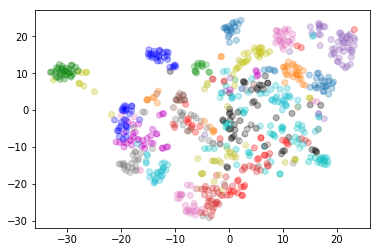

In [52]:
# visualize it
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

tsne_one = tsne_pca_results[:, 0]
tsne_two = tsne_pca_results[:, 1]
# problematic 
colors = []
plt.scatter(x = tsne_one[:n_sne], y = tsne_two[:n_sne], c = webcam_labels_rand[:n_sne], cmap=matplotlib.colors.ListedColormap(colors), alpha = 0.3) 

In [ ]:
# denoise using Prof. Deustch's method 